## Analysis code for results reported in "To follow or not to follow - Using Machine Learning to predict political attitudes and behavior from Twitter data"

In [1]:
'''
Final analysis notebook containing all results and figures 

Note: To make our results reproducible, we saved the weights of the trained VAE, 
load them into a vanilla model of the same architecture and set a seed to make the VAE z-sampling layer deterministic in this script.

Author: Nils Brandenstein
Date: 05.12.2023
'''

'\nFinal analysis notebook containing all results and figures \n\nNote: To make our results reproducible, we saved the weights of the trained VAE, \nload them into a vanilla model of the same architecture and set a seed to make the VAE z-sampling layer deterministic in this script.\n\nAuthor: Nils Brandenstein\nDate: 05.12.2023\n'

## Load libraries and data

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
import scipy
import matplotlib.pyplot as plt
import model
import os

#set CPU computing for reproducibility of VAE and seeds 
os.environ['TF_DETERMINISTIC_OPS'] = '1' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
seed = 42
random.seed(seed)
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
from tensorflow import keras
import tensorflow.keras.backend as K

tf.config.set_visible_devices([], 'GPU')
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
# Read data
df_train = pd.read_parquet("data_first_train.parquet.gzip") # Training data
df_val = pd.read_parquet("data_first_val.parquet.gzip") # Validation data
test = pd.read_parquet("foll_matrix_sample_matchClean.parquet.gzip") # Read in follower matrix
selfr = pd.read_excel('df_vp_reduced.xlsx') # Read in self report data
names = pd.read_excel('list_politicians_final_wParties.xlsx', skiprows=2) # Read in Table with pol names
self_snt = pd.read_excel('sonntag.xlsx') # read voting intention (sonntag frage) 

## Preprocess datasets

In [4]:
# Remove columns which are not political accounts
df_train = df_train.drop(columns=['BgmLudwig.csv', 'MullerAltermatt.csv'])
df_val = df_val.drop(columns=['BgmLudwig.csv', 'MullerAltermatt.csv'])

df_train = df_train.reset_index(drop=True) # reset index
df_val = df_val.reset_index(drop=True) # reset index

df_train = df_train.drop(columns=['follower_id','Count', 'add_fol', 'dif','Unnamed: 0', '__index_level_0__']) # only use relevant columns
df_val = df_val.drop(columns=['follower_id','Count', 'add_fol', 'dif','Unnamed: 0', '__index_level_0__']) # only use relevant columns

x_train = df_train.copy() # set x_train
x_val = df_val.copy() # set x_val
x_test = test.copy() # set x_test

In [5]:
# remove suffix from colnames
x_train.columns = x_train.columns.str.rsplit('.', 1).str[0]
x_val.columns = x_val.columns.str.rsplit('.', 1).str[0]
x_test.columns = x_test.columns.str.rsplit('.', 1).str[0]

# concat train and val data for plotting 
x_full = pd.concat([x_train, x_val], axis=0)

In [6]:
# print dimensions of data
print("Dimensions of x_train: ", x_train.shape)
print("Dimensions of x_val: ", x_val.shape)
print("Dimensions of x_test: ", x_test.shape)

Dimensions of x_train:  (248407, 1427)
Dimensions of x_val:  (27601, 1427)
Dimensions of x_test:  (163, 1700)


## VAE

Define model structure

In [7]:
## Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers
def sampling_model(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma/2) * epsilon


In [8]:
# Specify dimensions for input/output and latent space layers
original_dim = x_train.shape[1] # number of features/columns
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=512, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=128, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling_model, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z], name='Encoder-Model') # Define encoder model

# ********** Create Decoder **********

#--- Input Layer (from the latent space)
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling') # Input layer 

#--- Hidden Layer
h_dec = Dense(units=128, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=512, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3) # Output layer

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model') # Define decoder model

# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)) # note, outputs available from encoder model are z_mean, z_log_sigma and z
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

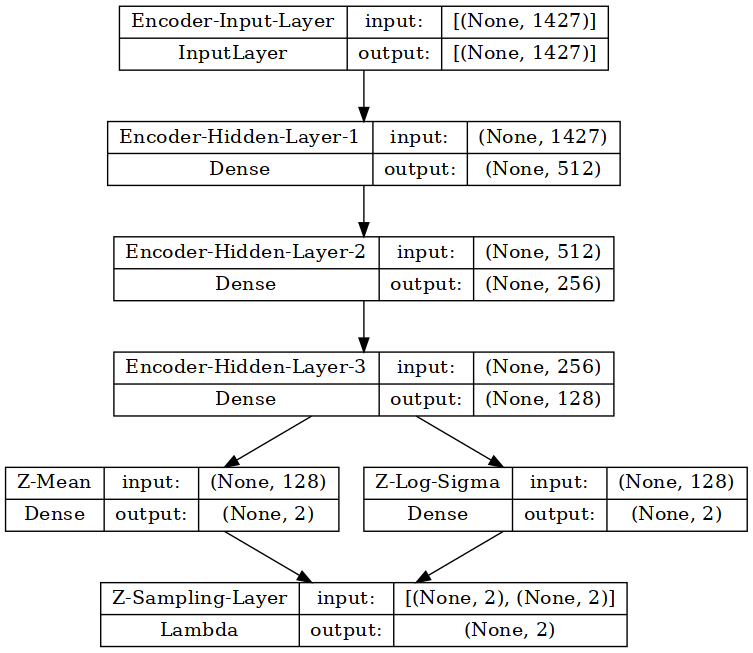

In [8]:
# Display model diagram
plot_model(encoder, show_shapes=True, dpi=100)

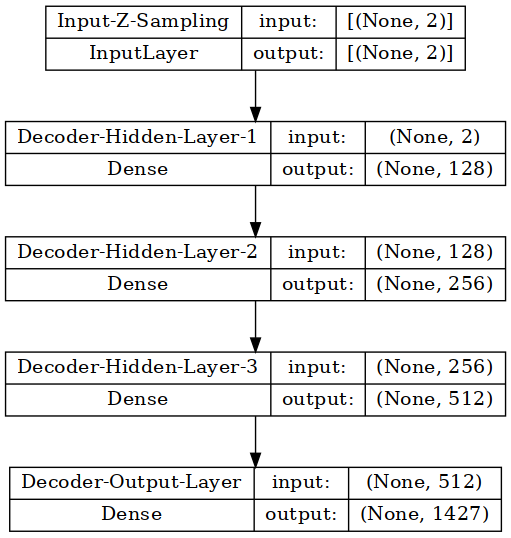

In [9]:
plot_model(decoder, show_shapes=True, dpi=100)

Define Training functions, losses and callbacks

In [9]:
## Loss function with KL annealing: https://deepakbaby.in/post/vae-insights/

# define train settings
def train_settings():
    # total number of epochs
    n_epochs = 60
    # The number of epochs at which KL loss should be included
    klstart = 20
    # number of epochs over which KL scaling is increased from 0 to 1
    kl_annealtime = 5
    # Starting weight of annealing
    weight = K.variable(0.)
    return n_epochs, klstart, kl_annealtime, weight
n_epochs, klstart, kl_annealtime, weight = train_settings()

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./ kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))

class Saver(Callback): # save models after annealing ended
    def __init__(self, encoder = encoder, model = vae):
        self.encoder = encoder
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
        if epoch == (klstart+kl_annealtime+2):  # Save models after reaching end of annealing time + 2 epochs
            print('start model saving period')
            self.model.save('VarAutoEnc_t.hdf5')
            self.encoder.save('Enc_t.hdf5')

class CustomStopper(tf.keras.callbacks.EarlyStopping): # stop after annealing ended
    def __init__(self, patience = 3, start_epoch=(klstart+kl_annealtime+2), monitor = 'val_loss', restore_best_weights = True): # start tracking only after annealing ended
        super(CustomStopper, self).__init__()
        self.monitor = monitor
        self.start_epoch = start_epoch
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.start_epoch:
            print('Start tracking early stopping')
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

def recon_loss(visible, outpt): # reconstruction loss
    reconstruction_loss = original_dim*binary_crossentropy(visible, outpt)                                              
    return K.mean(reconstruction_loss)

def latent_loss(inputs,outputs): # KL loss
    kl_loss =  -0.5*K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)    
    return K.mean(kl_loss)

def total_loss(visible, outpt): # total loss
    reconstruction_loss = original_dim*binary_crossentropy(visible, outpt)                                              
    kl_loss =  -0.5*K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(reconstruction_loss + (weight* kl_loss))
    
def bacc(visible, outpt): # balanced accuracy
    y_true = tf.reshape(tf.round(visible), [-1])
    y_pred = tf.reshape(tf.round(outpt), [-1])

    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(y_true * y_pred)
    pos_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp/(pos_pos + K.epsilon())
    bacc = (sensitivity+specificity)/2
    return bacc

def compile_settings(weight):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    stop = CustomStopper()
    cpk = Saver()
    callbacks = [AnnealingCallback(weight), stop, cpk]
    return opt, callbacks


In [10]:
# Compile model
opt, callbacks = compile_settings(weight)
vae.compile(optimizer=opt, loss=total_loss, metrics=[recon_loss, latent_loss, bacc])

# Fit model

In [25]:
#history = vae.fit(x_train, x_train, epochs=n_epochs, batch_size=256, validation_split = 0.1, callbacks=callbacks)

Train on 223566 samples, validate on 24841 samples


2023-04-19 11:57:32.003043: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/Decoder-Hidden-Layer-3_1/kernel/m/Assign' id:1984 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/Decoder-Hidden-Layer-3_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/Decoder-Hidden-Layer-3_1/kernel/m, training_2/Adam/Decoder-Hidden-Layer-3_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/60
223488/223566 [============================>.] - ETA: 0s - loss: 90.1848 - recon_loss: 90.1848 - latent_loss: 15.8362 - bacc: 0.5624

/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-04-19 11:57:41.200061: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:1603 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/Decoder-Model_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Current KL Weight is 0.0
223566/223566 [==============================] - 10s 44us/sample - loss: 90.1762 - recon_loss: 90.1566 - latent_loss: 15.8464 - bacc: 0.5625 - val_loss: 64.2653 - val_recon_loss: 64.2457 - val_latent_loss: 23.7316 - val_bacc: 0.6060
Epoch 2/60
223566/223566 [==============================] - 9s 40us/sample - loss: 62.1569 - recon_loss: 62.1579 - latent_loss: 27.6753 - bacc: 0.6014 - val_loss: 60.2437 - val_recon_loss: 60.3043 - val_latent_loss: 27.0879 - val_bacc: 0.6194
Epoch 3/60
223566/223566 [==============================] - 10s 43us/sample - loss: 58.7742 - recon_loss: 58.7719 - latent_loss: 27.0280 - bacc: 0.6436 - val_loss: 57.9904 - val_recon_loss: 57.9426 - val_latent_loss: 27.6249 - val_bacc: 0.6573
Epoch 4/60
223566/223566 [==============================] - 9s 42us/sample - loss: 56.9663 - recon_loss: 56.9679 - latent_loss: 30.1115 - bacc: 0.6608 - val_loss: 56.4868 - val_recon_loss: 56.8796 - val_latent_loss: 30.2824 - val_bacc: 0.6647
Epoch 5/60
2

CHECK PERFORMANCE

Load trained models.
Note: If fresh fit, skip following two cells

In [11]:
# Load saved encoder 
encoder_l = load_model('Enc.hdf5', custom_objects={"total_loss": total_loss, 'recon_loss' :recon_loss, 'latent_loss':latent_loss,
'bacc':bacc}, compile=False)
encoder_l = Model(encoder_l.layers[0].input, encoder_l.layers[-1].output)

# Load complete saved model
vae_l = load_model('VarAutoEnc.hdf5', custom_objects={"total_loss": total_loss, 'recon_loss' :recon_loss, 'latent_loss':latent_loss,
'bacc':bacc}, compile=False)

2024-01-12 14:07:53.320023: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 14:07:53.336942: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


In [12]:
# Set weights from saved model to vanilla model
w1 = vae_l.get_weights() #load weights from saved model 
vae_t = model.vanilla_fullmodel(x_train, w1) # load weights onto vanilla model
vae_t.compile(optimizer=opt, loss=total_loss, metrics=[recon_loss, latent_loss, bacc]) #compile model 

/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-09 17:01:05.163135: W tensorflow/c/c_api.cc:291] Operation '{name:'Decoder-Model_2/Decoder-Output-Layer/Sigmoid' id:1314 op device:{requested: '', assigned: ''} def:{{{node Decoder-Model_2/Decoder-Output-Layer/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](Decoder-Model_2/Decoder-Output-Layer/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 17:01:05.204798: W tensorflow/c/c_api.cc:291] Operation '{name:'count_5/Assign' id:1417 op device:{requested: '', assigned: ''} def:{{{node count_5/Assign}

Brier Score:  0.012695231788505058
Balanced accuracy score:  0.69
MCC:  0.52
Proportion correctly predicted 0.9873047682114949
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99 348648999
           1       0.70      0.39      0.50   5827790

    accuracy                           0.99 354476789
   macro avg       0.85      0.69      0.75 354476789
weighted avg       0.99      0.99      0.99 354476789



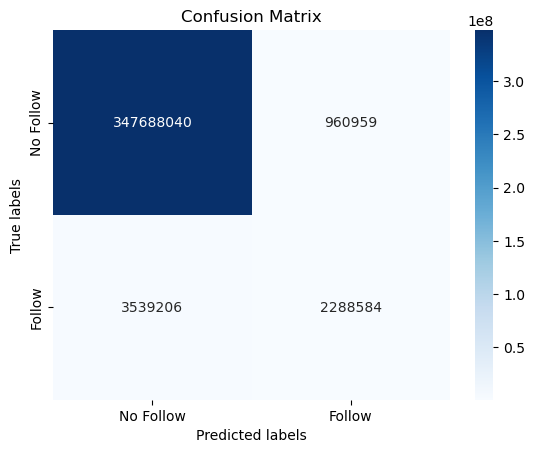

In [12]:
#### TRAIN SET PERFORMANCE ####

#reconstruct original matrix from fresh model
#pred = vae.predict(x_train)

#reconstruct original matrix from loaded model
pred = vae_t.predict(x_train)

# Get performance of autoencoder on train set
model.mlmetrics(np.array(x_train),pred) 

Brier Score:  0.012726299208104315
Balanced accuracy score:  0.69
MCC:  0.52
Proportion correctly predicted 0.9872737007918957
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99  38740129
           1       0.70      0.39      0.50    646498

    accuracy                           0.99  39386627
   macro avg       0.85      0.69      0.75  39386627
weighted avg       0.99      0.99      0.99  39386627



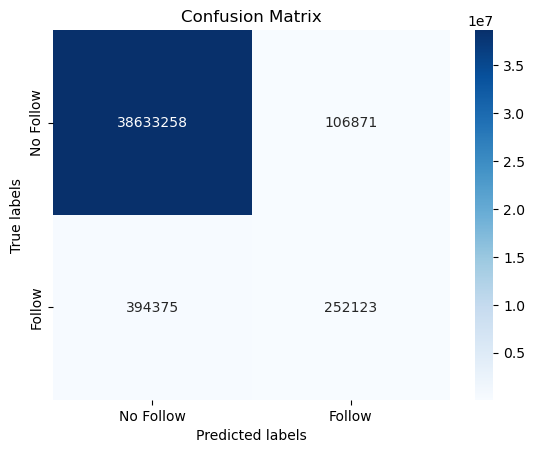

In [13]:
#### VALIDATION SET PERFORMANCE ####

#reconstruct original matrix from fresh model
#pred = vae.predict(x_val)

#reconstruct original matrix from loaded model
pred = vae_t.predict(x_val)

# Get performance of autoencoder on val set
model.mlmetrics(np.array(x_val),pred)

In [14]:
# Preprocess sample test set for performance check
x_test.columns = x_test.columns.str.rsplit('.', 1).str[0] #remove suffix
train_cols = x_train.columns
test_cols= x_test.columns
common_cols = train_cols.intersection(test_cols) #get test_cols
x_test = x_test[list(common_cols)] #get common cols
x_test = x_test.loc[(x_test!=0).any(axis=1)]  # remove rows with all zeros

# Calculate how many accounts each sample in the test set follows, minus randomid
x_test['Count'] = x_test.iloc[:, :-1].sum(axis=1)

# print rows with following count of political accounts equal to or over 10 
print("Number of rows with count equal to or over 10: ", x_test[x_test['Count'] >= 10].shape[0])

# remove column count
x_test = x_test.drop(columns=['Count'])

Number of rows with count equal to or over 10:  46


Brier Score:  0.009339685418666416
Balanced accuracy score:  0.69
MCC:  0.47
Proportion correctly predicted 0.9906603145813336
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    168046
           1       0.58      0.39      0.46      1767

    accuracy                           0.99    169813
   macro avg       0.78      0.69      0.73    169813
weighted avg       0.99      0.99      0.99    169813



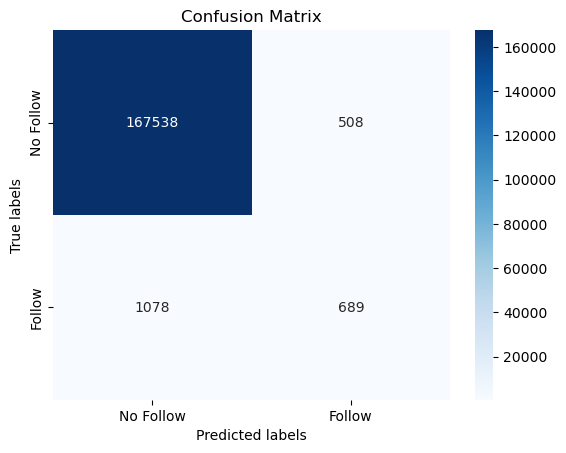

In [15]:
#### TEST SET PERFORMANCE (SAMPLE) ####

#reconstruct original matrix from fresh model
#pred = vae.predict(x_test)

#reconstruct original matrix from loaded model
pred = vae_t.predict(x_test)

# Get performance of autoencoder on test set
model.mlmetrics(np.array(x_test),pred) 

## Naive classifier

In [ ]:
# Calculate ratio of follow to non follow decisions in full dataset --> BASE RATE TO COMPARE ACCURACY/Prop. Cor. predicted To
unique, counts = np.unique(np.array(x_full), return_counts=True)
100 - (counts[1]/counts[0]*100)

98.32873781630754

Brier Score:  0.016440540483456025
Balanced accuracy score:  0.5
MCC:  0.0
Proportion correctly predicted 0.983559459516544


/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99 348648999
           1       0.00      0.00      0.00   5827790

    accuracy                           0.98 354476789
   macro avg       0.49      0.50      0.50 354476789
weighted avg       0.97      0.98      0.98 354476789

Brier Score:  0.016414149909308052
Balanced accuracy score:  0.5
MCC:  0.0
Proportion correctly predicted 0.983585850090692


/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99  38740129
           1       0.00      0.00      0.00    646498

    accuracy                           0.98  39386627
   macro avg       0.49      0.50      0.50  39386627
weighted avg       0.97      0.98      0.98  39386627

Brier Score:  0.010405563767202747
Balanced accuracy score:  0.5
MCC:  0.0
Proportion correctly predicted 0.9895944362327973
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    168046
           1       0.00      0.00      0.00      1767

    accuracy                           0.99    169813
   macro avg       0.49      0.50      0.50    169813
weighted avg       0.98      0.99      0.98    169813



/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


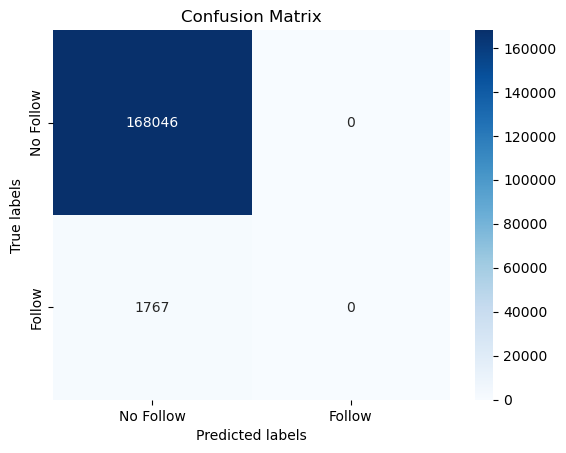

In [16]:
# Create following matrix with all zeros (most frequent class) for all datasets
x_train_zeros = np.zeros(x_train.shape)
x_val_zeros = np.zeros(x_val.shape)
x_test_zeros = np.zeros(x_test.shape)

# Get model 
model.mlmetrics(np.array(x_train),x_train_zeros) 
model.mlmetrics(np.array(x_val),x_val_zeros)
model.mlmetrics(np.array(x_test),x_test_zeros)

## Further preprocessing & descriptives

In [13]:
# Concat dataframe
x_full = pd.concat([x_train, x_val], axis=0)

# Load weights from saved encoder to vanilla encoder and predict latent dimensions
w = encoder_l.get_weights()
X = model.vanilla_encoder(x_full, w).predict(x_full)
#pd.DataFrame(X).to_csv('encoder_predFull.csv') # Save encoder output for full dataset

# Predict latent dimensions from scratch
#X = encoder.predict(x_full) # predict latent dimensions for full dataset (train + val)

/home/nils/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PREPROCESS DATA FOR PLOTTING

In [14]:
# Preprocess party dataset
def partydf_preproc(x_train, names):
    # Drop irrelevant columns + rename columns
    names = names.drop(columns=['Name', 'user_id', 'evtl. Anmerkungen'])
    names.columns = names.columns.str.split().str[0]
    # get intersecting cols and keep matching names
    common_cols = set(list(names['user_name'])).intersection(list(x_train.columns))
    names = names[names['user_name'].isin(common_cols)]
    return names

In [15]:
# Function to create col_lists of policital accounts
def get_pols(names, party):
    p = names.loc[names['Partei'] == party]
    col_list = list(p.user_name.values)
    return col_list

In [16]:
# Create lists of names per party
names = partydf_preproc(x_train, names)
col_list_afd = get_pols(names, 'AfD')
col_list_cdu = get_pols(names, 'CDU')
col_list_csu = get_pols(names, 'CSU')
col_list_fdp = get_pols(names, 'FDP')
col_list_gruene = get_pols(names, 'Grüne')
col_list_linke = get_pols(names, 'Linke')
col_list_spd = get_pols(names, 'SPD')
col_list_cdu_csu = col_list_cdu + col_list_csu # combine CDU and CSU

# nest lists
col_list = [col_list_afd, col_list_cdu_csu, col_list_fdp, col_list_gruene, col_list_linke, col_list_spd]
party = ['AfD', 'CDU_CSU', 'FDP', 'Grüne', 'Linke', 'SPD']

In [17]:
# function to append party columns to dataframe and sum up
def get_party(df, col_list, party, X, dataset):
    if dataset == "full":
        df['1. Dimension'] = X[:,0]
        df['2. Dimension'] = X[:,1]
    for p, l in zip(party,col_list):
        df[p] = df[l].sum(axis=1)
    return df

In [18]:
# Full dataset 
t = pd.DataFrame(x_full, columns=x_full.columns.values)
t = get_party(t, col_list,party,  X, 'full')

In [19]:
# Train
t_tr = pd.DataFrame(x_train, columns=x_train.columns.values)
t_tr = get_party(t_tr, col_list,party,  X,'train')

In [20]:
# Val 
t_val= pd.DataFrame(x_val, columns=x_val.columns.values)
t_val = get_party(t_val, col_list,party,  X,'val')

In [21]:
# Test
test = pd.read_parquet("foll_matrix_sample_matchClean.parquet.gzip") #read foll matrix of sample data again
test.columns = test.columns.str.rsplit('.', 1).str[0] #remove suffix
full_cols = x_full.columns
test_cols= test.columns
common_cols = full_cols.intersection(test_cols) #get test_cols
x_test_c = test[list(common_cols)] # only keep intersecting columns

t_ts= get_party(x_test_c, col_list,party,  X,'test')

/home/nils/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
# Get absolute number and percentage of accounts followed per party (AfD, CDU, FDP, Grüne, Linke, SPD), sum over columns
# Output: Series with index = party, value = total number of accounts followed by all users in that party
def party_fols(t):
    print('Descriptives Grüne', t[t['Grüne'] != 0]['Grüne'].describe())
    print('Descriptives Linke', t[t['Linke'] != 0]['Linke'].describe())
    print('Descriptives SPD', t[t['SPD'] != 0]['SPD'].describe())
    print('Descriptives FDP', t[t['FDP'] != 0]['FDP'].describe())
    print('Descriptives CDU/CSU', t[t['CDU_CSU'] != 0]['CDU_CSU'].describe())
    print('Descriptives AFD', t[t['AfD'] != 0]['AfD'].describe())

    tot_afd = t.AfD.sum()
    tot_CDU_CSU = t.CDU_CSU.sum()
    tot_FDP = t.FDP.sum()
    tot_Gruene = t.Grüne.sum()
    tot_Linke = t.Linke.sum()
    tot_SPD = t.SPD.sum()

    # get table of all tot, calculate percentage sort by tot
    tot = pd.DataFrame([tot_afd, tot_CDU_CSU, tot_FDP, tot_Gruene, tot_Linke, tot_SPD], index = ['AfD', 'CDU_CSU', 'FDP', 'Gruene', 'Linke', 'SPD'], columns = ['total_follows_all_users'])
    tot['perc'] = (tot['total_follows_all_users']/tot['total_follows_all_users'].sum())*100
    print('Follow count \n', tot.sort_values(by = 'perc', ascending = False))
    print('total no of accounts followed: ', tot['total_follows_all_users'].sum())

In [23]:
party_fols(t_tr)

Descriptives Grüne count    215612.000000
mean          6.688097
std          10.264591
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         299.000000
Name: Grüne, dtype: float64
Descriptives Linke count    173344.000000
mean          3.786794
std           4.820019
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         103.000000
Name: Linke, dtype: float64
Descriptives SPD count    231338.000000
mean          6.772372
std           8.640436
min           1.000000
25%           3.000000
50%           5.000000
75%           8.000000
max         266.000000
Name: SPD, dtype: float64
Descriptives FDP count    174879.000000
mean          3.662515
std           6.844654
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         144.000000
Name: FDP, dtype: float64
Descriptives CDU/CSU count    199455.000000
mean          5.603650
std           8.2

In [24]:
party_fols(t_val)

Descriptives Grüne count    23894.000000
mean         6.712103
std         10.263287
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        199.000000
Name: Grüne, dtype: float64
Descriptives Linke count    19221.000000
mean         3.825399
std          4.854266
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         83.000000
Name: Linke, dtype: float64
Descriptives SPD count    25687.000000
mean         6.733951
std          8.085080
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        214.000000
Name: SPD, dtype: float64
Descriptives FDP count    19464.000000
mean         3.628648
std          6.751153
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        120.000000
Name: FDP, dtype: float64
Descriptives CDU/CSU count    22187.000000
mean         5.551945
std          7.715015
min          1.000000
25%    

In [25]:
party_fols(t_ts)

Descriptives Grüne count    83.000000
mean      7.397590
std      13.530399
min       1.000000
25%       1.500000
50%       3.000000
75%       6.000000
max      75.000000
Name: Grüne, dtype: float64
Descriptives Linke count    47.000000
mean      3.765957
std       4.033624
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      21.000000
Name: Linke, dtype: float64
Descriptives SPD count    102.000000
mean       5.735294
std       11.495093
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max      107.000000
Name: SPD, dtype: float64
Descriptives FDP count    40.000000
mean      5.275000
std       7.642618
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      32.000000
Name: FDP, dtype: float64
Descriptives CDU/CSU count    41.000000
mean      3.341463
std       4.998048
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      28.000000
Name: CDU_CSU, dtype: float64
D

# Plots

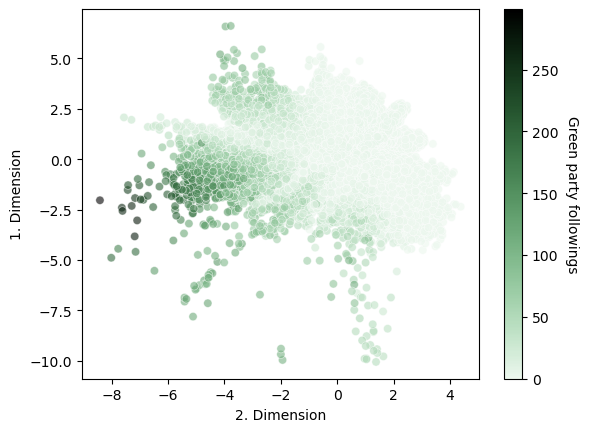

In [32]:
# Green party
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='Grüne', palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['Grüne'].min(), t['Grüne'].max())
sm = plt.cm.ScalarMappable(cmap= sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('Green party followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/green.png', dpi=300, bbox_inches='tight')
plt.show(g)

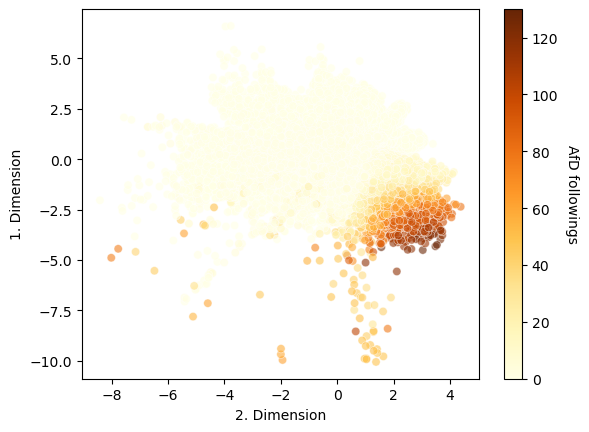

In [33]:
# AfD
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='AfD', palette = sns.color_palette("YlOrBr", as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['AfD'].min(), t['AfD'].max())
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("YlOrBr", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('AfD followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/afd.png', dpi=300, bbox_inches='tight')
plt.show(g)

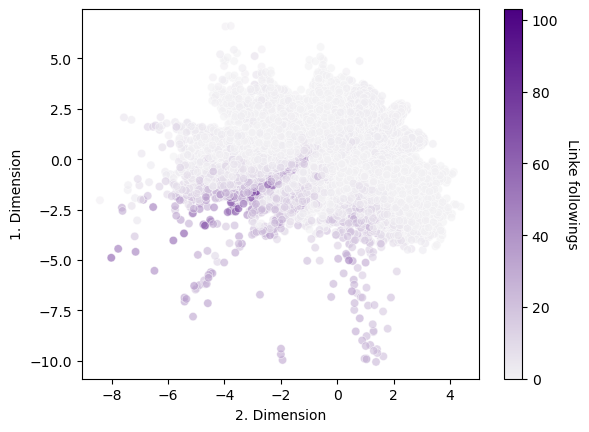

In [34]:
# Linke
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='Linke', palette = sns.light_palette("indigo", as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['Linke'].min(), t['Linke'].max())
sm = plt.cm.ScalarMappable(cmap= sns.light_palette("indigo", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('Linke followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/linke.png', dpi=300, bbox_inches='tight')
plt.show(g)

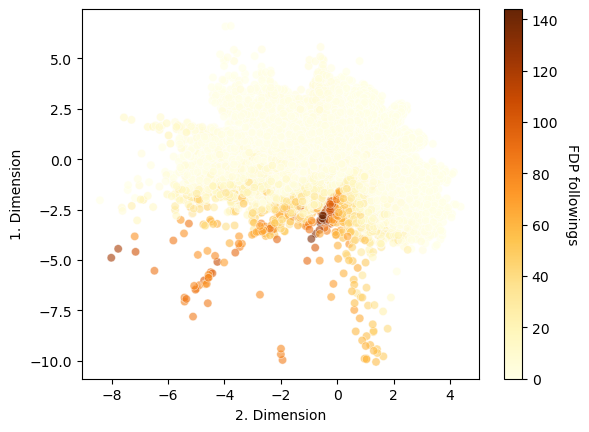

In [35]:
# FDP
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='FDP', palette = sns.color_palette("YlOrBr", as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['FDP'].min(), t['FDP'].max())
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("YlOrBr", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('FDP followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/fdp.png', dpi=300, bbox_inches='tight')
plt.show(g)

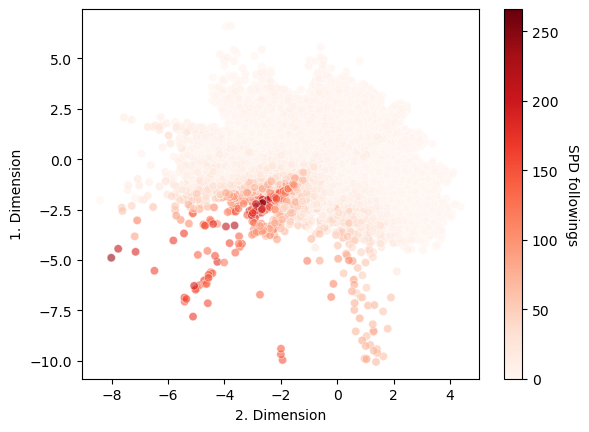

In [36]:
# SPD
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='SPD', palette = sns.color_palette("Reds", as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['SPD'].min(), t['SPD'].max())
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("Reds", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('SPD followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/spd.png', dpi=300, bbox_inches='tight')
plt.show(g)

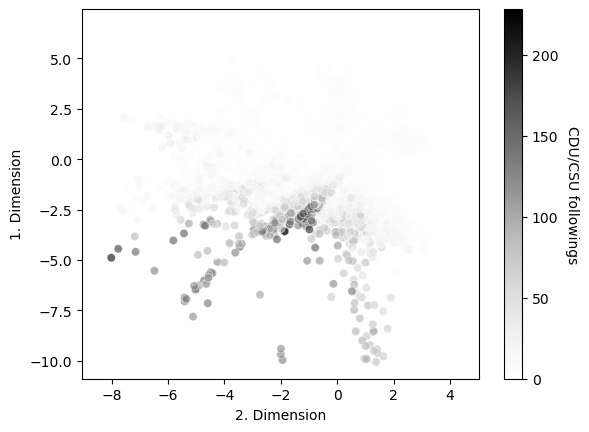

In [37]:
# CDU/CSU
g = sns.scatterplot(y='1. Dimension', x='2. Dimension', hue='CDU_CSU', palette = sns.color_palette("Greys", 8, as_cmap=True), data=t, alpha=0.6) 
sns.reset_orig()
norm = plt.Normalize(t['CDU_CSU'].min(), t['CDU_CSU'].max())
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("Greys", 8, as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('CDU/CSU followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/ML/cdu_csu.png', dpi=300, bbox_inches='tight')
plt.show(g)

## Self report correlation with latent dim Autoencoder

In [42]:
### PREPROCESS DATASETS
test = pd.read_parquet("foll_matrix_sample_matchClean.parquet.gzip") #read foll matrix of sample data again
test.columns = test.columns.str.rsplit('.', 1).str[0] #remove suffix
full_cols = x_full.columns
test_cols= test.columns
common_cols = full_cols.intersection(test_cols) #get test_cols
x_test_c = test[list(common_cols)] # only keep intersecting columns
# Remove rows with all zeros for comparability with CA model --> SUPPLEMENTARY ANALYSES
x_test_c['randomid'] = test['randomid'] # copy randomid over
s = x_test_c.iloc[:,:-1].eq(0).all(1) #check if all values in a row are 0 except the last one (randomid), return boolean series of index
x_test_c = x_test_c.drop(s[s].index, axis= 'index') # remove rows with all zeros by index

/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [48]:
# Load weights from loaded encoder and predict
w = encoder_l.get_weights()
encoder_t = model.vanilla_encoder(x_test_c.iloc[:,:-1], w)
X3 = encoder_t.predict(x_test_c.iloc[:,:-1]) #predict

# Copy dataset and set lat_id
t1 = x_test_c.copy()
t1['lat_id'] = pd.Series(X3[:,-1], index=x_test_c.index) # append to dataframe

# Merge datasets self report, sonntag and sample data
test2 = t1.merge(selfr[['randomid', 'left_right']], left_on='randomid', right_on='randomid') #merge first dataset
test2 = test2.merge(self_snt[['randomid', 'sundayq_1']], left_on='randomid', right_on='randomid') #merge sec dataset
x_test2 = test2.copy()
x_test2 = test2.dropna(axis=0) #drop NAs

x_test2['sundayq_1'] = x_test2['sundayq_1'].astype('category') #recode sunday question to categorical 
x_test2['sundayq_1'].replace({1: 'AfD', 2: '90/Greens', 3:'CDU/CSU', 4:'FDP', 5:'LINKE', 6:'SPD', 7:'Other', 8:'No vote'}, inplace=True) #label 

# Spearman correlation between latent dimension and self report left right
corLR = scipy.stats.spearmanr(x_test2['lat_id'], x_test2['left_right'])
print('Correlation latent dim with ideology (left-right):', np.round(corLR.correlation, 2),'\n', 'p-value', corLR.pvalue)

Correlation latent dim with ideology (left-right): 0.46 
 p-value 1.4708977291580633e-07


2023-12-13 16:47:27.374349: W tensorflow/c/c_api.cc:291] Operation '{name:'Z-Log-Sigma_7/kernel/Assign' id:2188 op device:{requested: '', assigned: ''} def:{{{node Z-Log-Sigma_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Z-Log-Sigma_7/kernel, Z-Log-Sigma_7/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-13 16:47:27.452663: W tensorflow/c/c_api.cc:291] Operation '{name:'Z-Sampling-Layer_7/add' id:2209 op device:{requested:

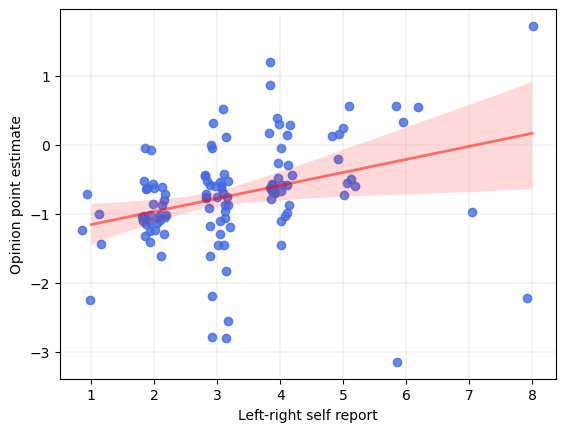

In [29]:
# Regplot of latent latent dim value x left-right self report
g = sns.regplot(y='lat_id', x='left_right', data=x_test2, ci=95, x_jitter=0.2, scatter_kws={'color': 'royalblue'}, line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})
sns.reset_orig()
plt.grid(axis='both', linewidth=0.2)
plt.xlabel('Left-right self report')
plt.ylabel('Opinion point estimate')
plt.show()

In [47]:
#x_test2.to_csv('vot_pred_forR.csv') #export to csv for further analysis in R

In [34]:
# Descriptives 
print(x_test2[['lat_id', 'left_right']].describe())
print(x_test2['sundayq_1'].value_counts())

           lat_id  left_right
count  119.000000  119.000000
mean    -0.723175    3.285714
std      0.755917    1.328583
min     -3.149467    1.000000
25%     -1.074174    2.000000
50%     -0.703287    3.000000
75%     -0.466153    4.000000
max      1.727566    8.000000
90/Greens    54
SPD          19
Other        18
LINKE        15
FDP           7
CDU/CSU       4
No vote       1
AfD           1
Name: sundayq_1, dtype: int64


## Check voting intention 

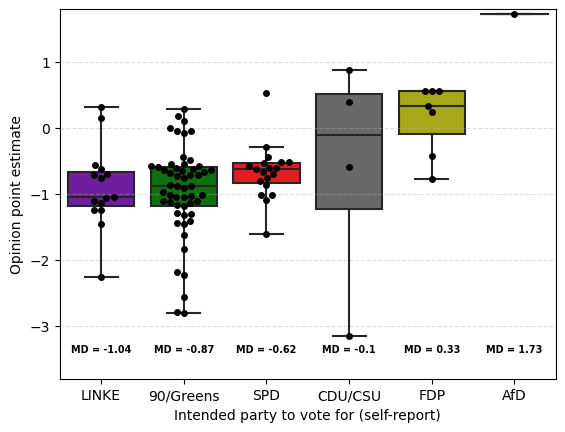

In [33]:
# Violin of latent dim value x party voted for, excluding other and no vote
x_test3 = x_test2[(x_test2['sundayq_1']!= 'Other') & (x_test2['sundayq_1']!='No vote')]
palette = ['#7209B7', 'g', 'r', 'dimgrey', 'y', 'b']
box = sns.boxplot(x='sundayq_1', y='lat_id', data=x_test3, palette = palette, whis = 3, showfliers = False)
swarm = sns.swarmplot(x='sundayq_1', y='lat_id', data=x_test3, color = 'black', dodge = True)
tcks = len(box.get_xticklabels())
medians = x_test3.groupby(['sundayq_1'])['lat_id'].median().round(2).sort_values()
plt.ylim(-3.8,1.8)
ver_offset = -3.4
for tick in range(tcks):
     box.text(tick,ver_offset,str('MD = ' + str(medians[tick])), 
            horizontalalignment='center',size='x-small',color='black',weight='semibold')

plt.grid(axis='y', linestyle='--', alpha = 0.4)
plt.xlabel('Intended party to vote for (self-report)')
plt.ylabel('Opinion point estimate')

#plt.savefig('~', dpi=300, bbox_inches='tight')
plt.show()

# Correspondence Analysis

In [26]:
# Read in results of ca conducted in R and append latent dim values to full dataset
ca = pd.read_csv('df_ca.csv', dtype={'follower_id': np.int64}, usecols=['follower_id', 'Dim 1', 'Dim 2']) # read in ca results (latent dim predictions) for train and val set
x_full = pd.concat([x_train, x_val], axis=0)
x_full = x_full.reset_index(drop=True)
ca = pd.concat([x_full, ca], axis=1) #merge ca with x_full

Plotting

In [27]:
# function to append party columns to dataframe and sum up
t2 = pd.DataFrame(ca, columns=ca.columns.values)

def get_party(df, col_list, party):
    
    for p, l in zip(party,col_list):
        df[p] = df[l].sum(axis=1)
    return df

In [28]:
t2 = get_party(t2, col_list,party)

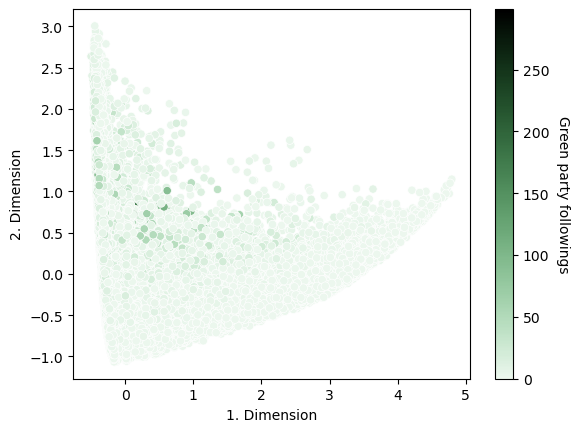

In [18]:
# Green party
g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='Grüne', palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['Grüne'].min(), t2['Grüne'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('Green party followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

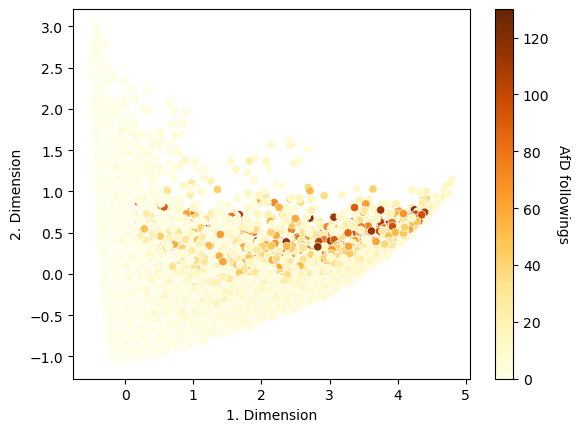

In [19]:
#sns.scatterplot(y='Dim 2', x='Dim 1', hue='AfD', hue_order=hue_order, palette= "YlOrBr", data=t2, alpha=0.6)

g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='AfD', palette = sns.color_palette('YlOrBr', as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['AfD'].min(), t2['AfD'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.color_palette('YlOrBr', as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('AfD followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

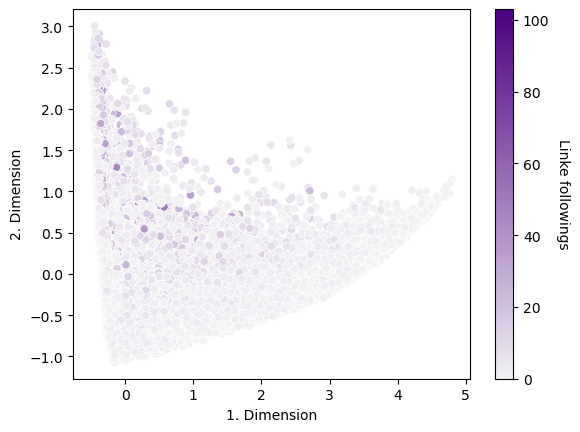

In [20]:
# Do the same plot for links, use purple palette
g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='Linke', palette = sns.light_palette("indigo", as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['Linke'].min(), t2['Linke'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.light_palette("indigo", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('Linke followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

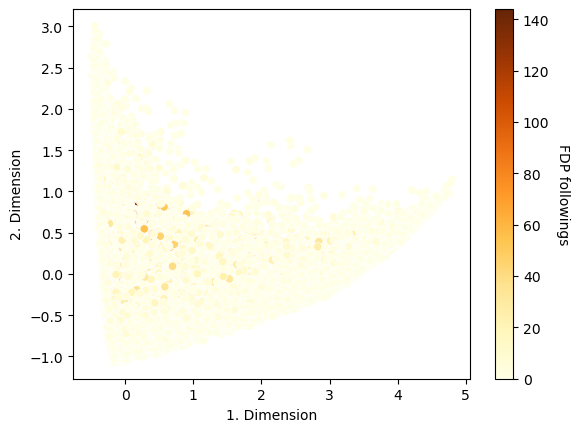

In [21]:
# Do the same plot for fdp, use yellow palette
g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='FDP', palette = sns.color_palette("YlOrBr", as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['FDP'].min(), t2['FDP'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("YlOrBr", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('FDP followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

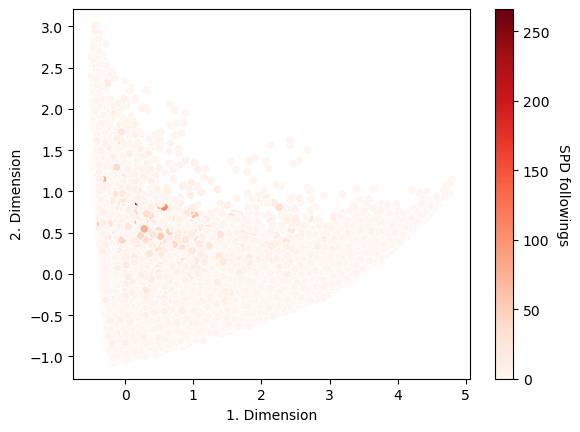

In [22]:
# Do the same plot for spd, use red palette
g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='SPD', palette = sns.color_palette("Reds", as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['SPD'].min(), t2['SPD'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("Reds", as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('SPD followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

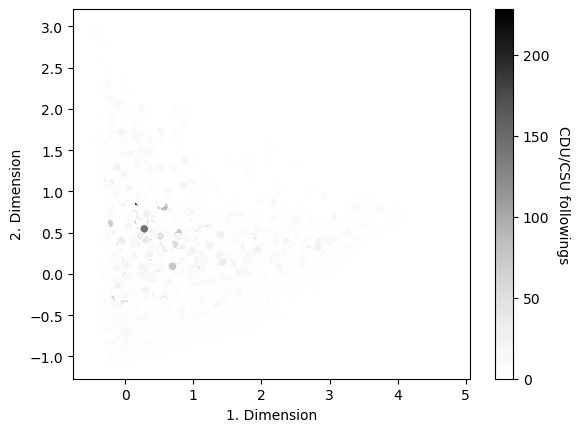

In [23]:
# Do the same plot for cdu/csu, use black palette
g = sns.scatterplot(y='Dim 2', x='Dim 1', hue='CDU_CSU', palette = sns.color_palette("Greys", 8, as_cmap=True), data=t2) 
sns.reset_orig()
norm = plt.Normalize(t2['CDU_CSU'].min(), t2['CDU_CSU'].max())
plt.xlabel("1. Dimension")
plt.ylabel("2. Dimension")
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("Greys", 8, as_cmap=True), norm=norm)
sm.set_array([])
clb = plt.colorbar(sm)
clb.ax.set_ylabel('CDU/CSU followings',fontsize=10, rotation = 270, labelpad=15)
g.get_legend().set_visible(False)
plt.show(g)

## Compare median ideal points of parties with expert ratings (oes data)

In [29]:
# function to append party columns to dataframe and sum up
t2 = pd.DataFrame(ca, columns=ca.columns.values)

def get_party(df, col_list, party):    
    for p, l in zip(party,col_list):
        df[p] = df[l].sum(axis=1)
    return df
t2 = get_party(t2, col_list,party)

In [120]:
## Twitter estimates

# OES data
##read oes data and preprocess
oes = pd.read_stata('/home/nils/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/Analysis/OES21/oes21_medians_wide.dta')
oes = oes[['party', 'leftrightgeneral']]
oes = oes.append({'party': 'cdu/csu', 'leftrightgeneral': (oes.iloc[1,1]+oes.iloc[2,1])/2}, ignore_index=True) # mean of cdu/csu, new variable
oes.drop([1,2,4], inplace=True) # drop unused party columns

# standardize ideology scores
from sklearn.preprocessing import scale
oes['leftrightgeneral'] = scale(oes['leftrightgeneral'])

# standardize latent dimension CA
t2['Dim 1_s'] = scale(t2['Dim 1'])

# Select all users from dataset t for parties with >= median following sums: CA
green = t2.loc[t2['Grüne'] >= t2[t2['Grüne'] != 0]['Grüne'].median()]
afd = t2.loc[t2['AfD'] >= t2[t2['AfD'] != 0]['AfD'].median()]
links = t2.loc[t2['Linke'] >= t2[t2['Linke'] != 0]['Linke'].median()]
spd = t2.loc[t2['SPD'] >= t2[t2['SPD'] != 0]['SPD'].median()]
cduCsu = t2.loc[t2['CDU_CSU'] >= t2[t2['CDU_CSU'] != 0]['CDU_CSU'].median()]
fdp = t2.loc[t2['FDP'] >= t2[t2['FDP'] != 0]['FDP'].median()]


# Get median of lat_id for each party CA
greem_m = green['Dim 1_s'].median()
afd_m = afd['Dim 1_s'].median()
links_m = links['Dim 1_s'].median()
spd_m = spd['Dim 1_s'].median()
cduCsu_m = cduCsu['Dim 1_s'].median()
fdp_m = fdp['Dim 1_s'].median()

# standardize latent dimension ML
t['2. Dimension'] = scale(t['2. Dimension'])

# Select all users from dataset t for parties with >= median following sums: VAE
green2 = t.loc[t['Grüne'] >= t[t['Grüne'] != 0]['Grüne'].median()]
afd2 = t.loc[t['AfD'] >= t[t['AfD'] != 0]['AfD'].median()]
links2 = t.loc[t['Linke'] >= t[t['Linke'] != 0]['Linke'].median()]
spd2 = t.loc[t['SPD'] >= t[t['SPD'] != 0]['SPD'].median()]
cduCsu2 = t.loc[t['CDU_CSU'] >= t[t['CDU_CSU'] != 0]['CDU_CSU'].median()]
fdp2 = t.loc[t['FDP'] >= t[t['FDP'] != 0]['FDP'].median()]


# Get median of lat_id for each party ML
greem_m2 = green2['2. Dimension'].median()
afd_m2 = afd2['2. Dimension'].median()
links_m2 = links2['2. Dimension'].median()
spd_m2 = spd2['2. Dimension'].median()
cduCsu_m2 = cduCsu2['2. Dimension'].median()
fdp_m2 = fdp2['2. Dimension'].median()

/home/nils/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


In [51]:
# ## Twitter estimates Manifesto data

# # Manifesto data
# # load manifesto  
# ch = pd.read_csv('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/manifesto/MPDataset_MPDS2023a.csv', usecols=['countryname', 'partyabbrev', 'coderyear', 'rile'])
# ch['coderyear'] = ch['coderyear'].astype('str')

# # Filter dataset by parties, country and year 
# ch = ch.loc[((ch['countryname']=='Germany') & (ch['coderyear'] == '2021.0')) &
#               ((ch['partyabbrev'] == 'SPD') | (ch['partyabbrev'] == 'CDU/CSU') | 
#                 (ch['partyabbrev'] == 'FDP') | (ch['partyabbrev'] == 'AfD') | (ch['partyabbrev'] == '90/Greens') | (ch['partyabbrev'] == 'LINKE'))]

# # standardize rile
# ch['rile'] = (ch['rile'] - ch['rile'].mean()) / ch['rile'].std() 

# # standardize latent dimension CA
# t2['Dim 1_s'] = (t2['Dim 1'] - t2['Dim 1'].mean()) / t2['Dim 1'].std()

# # Select all users from dataset t for parties with >= median following sums: CA
# green = t2.loc[t2['Grüne'] >= t2[t2['Grüne'] != 0]['Grüne'].median()]
# afd = t2.loc[t2['AfD'] >= t2[t2['AfD'] != 0]['AfD'].median()]
# links = t2.loc[t2['Linke'] >= t2[t2['Linke'] != 0]['Linke'].median()]
# spd = t2.loc[t2['SPD'] >= t2[t2['SPD'] != 0]['SPD'].median()]
# cduCsu = t2.loc[t2['CDU_CSU'] >= t2[t2['CDU_CSU'] != 0]['CDU_CSU'].median()]
# fdp = t2.loc[t2['FDP'] >= t2[t2['FDP'] != 0]['FDP'].median()]


# # Get median of lat_id for each party CA
# greem_m = green['Dim 1_s'].median()
# afd_m = afd['Dim 1_s'].median()
# links_m = links['Dim 1_s'].median()
# spd_m = spd['Dim 1_s'].median()
# cduCsu_m = cduCsu['Dim 1_s'].median()
# fdp_m = fdp['Dim 1_s'].median()

# # standardize latent dimension ML
# t['2. Dimension'] = (t['2. Dimension'] - t['2. Dimension'].mean()) / t['2. Dimension'].std()

# # Select all users from dataset t for parties with >= median following sums: VAE
# green2 = t.loc[t['Grüne'] >= t[t['Grüne'] != 0]['Grüne'].median()]
# afd2 = t.loc[t['AfD'] >= t[t['AfD'] != 0]['AfD'].median()]
# links2 = t.loc[t['Linke'] >= t[t['Linke'] != 0]['Linke'].median()]
# spd2 = t.loc[t['SPD'] >= t[t['SPD'] != 0]['SPD'].median()]
# cduCsu2 = t.loc[t['CDU_CSU'] >= t[t['CDU_CSU'] != 0]['CDU_CSU'].median()]
# fdp2 = t.loc[t['FDP'] >= t[t['FDP'] != 0]['FDP'].median()]


# # Get median of lat_id for each party ML
# greem_m2 = green2['2. Dimension'].median()
# afd_m2 = afd2['2. Dimension'].median()
# links_m2 = links2['2. Dimension'].median()
# spd_m2 = spd2['2. Dimension'].median()
# cduCsu_m2 = cduCsu2['2. Dimension'].median()
# fdp_m2 = fdp2['2. Dimension'].median()

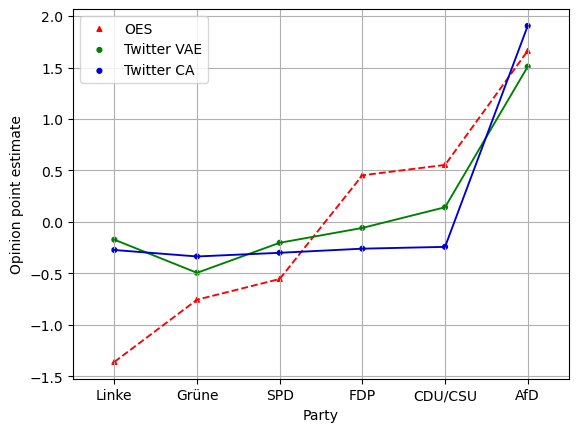

In [164]:
## Plot
# Plot median lat_id for each party in a pointplot
sns.pointplot(x='party', y='leftrightgeneral', markers='^', scale=0.5, data=oes, order=['linke',   'gruene', 'spd', 'fdp', 'cdu/csu', 'afd'], color = 'red', label='OES', linestyles='--')
sns.pointplot(x=['Linke',  'Grüne', 'SPD', 'FDP', 'CDU/CSU', 'AfD'], y=[links_m2,  greem_m2, spd_m2, fdp_m2, cduCsu_m2, afd_m2], color='green', markers='o', scale=0.5, label='Twitter VAE')
sns.pointplot(x=['Linke',  'Grüne', 'SPD', 'FDP', 'CDU/CSU', 'AfD'], y=[links_m,  greem_m, spd_m, fdp_m, cduCsu_m, afd_m], color='mediumblue', markers='o', scale=0.5, label='Twitter CA')

plt.ylabel('Opinion point estimate')
plt.xlabel('Party')
plt.legend()
plt.grid()
plt.savefig('/home/nils/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/oes_twitter.png', dpi=300, bbox_inches='tight')
plt.show()

## Self report correlation with ideal points: CA

In [44]:
## Load sunday and sample dims
X = pd.read_csv('df_caSAMPLE_new.csv') # read in ca results (latent dim predictions) for test set (sample data)

In [45]:
test2 = X.merge(selfr[['randomid', 'left_right']], left_on='randomid', right_on='randomid') #merge first dataset
x_test2 = test2.merge(self_snt[['randomid', 'sundayq_1']], left_on='randomid', right_on='randomid') #merge sec dataset

x_test2['sundayq_1'] = x_test2['sundayq_1'].astype('category') #recode sunday question to categorical 
x_test2['sundayq_1'].replace({1: 'AfD', 2: '90/Greens', 3:'CDU/CSU', 4:'FDP', 5:'LINKE', 6:'SPD', 7:'Other'}, inplace=True) #label 
x_test2 = x_test2.dropna() #drop nas introduced by all zeros in CA 

In [54]:
#x_test2.to_csv('vot_predCA_forR.csv') #export to csv for further analysis in R

In [10]:
# Descriptives 
print(x_test2[['Dim 1', 'left_right']].describe())
print(x_test2['sundayq_1'].value_counts())

            Dim 1  left_right
count  119.000000  119.000000
mean    -0.239976    3.285714
std      0.332088    1.328583
min     -0.432559    1.000000
25%     -0.324777    2.000000
50%     -0.285936    3.000000
75%     -0.248766    4.000000
max      3.142248    8.000000
90/Greens    54
SPD          19
Other        18
LINKE        15
FDP           7
CDU/CSU       4
8             1
AfD           1
Name: sundayq_1, dtype: int64


In [ ]:
## Correlation lat_id with self reported ideology

In [46]:
corLR = scipy.stats.spearmanr(x_test2['Dim 1'], x_test2['left_right'], nan_policy='omit') #correlation between left_right and dim1

In [47]:
print('Correlation latent dim with ideology (left-right):', np.round(corLR.correlation, 2),'\n', 'p-value', corLR.pvalue)

Correlation latent dim with ideology (left-right): 0.46 
 p-value 1.0442212676538761e-07


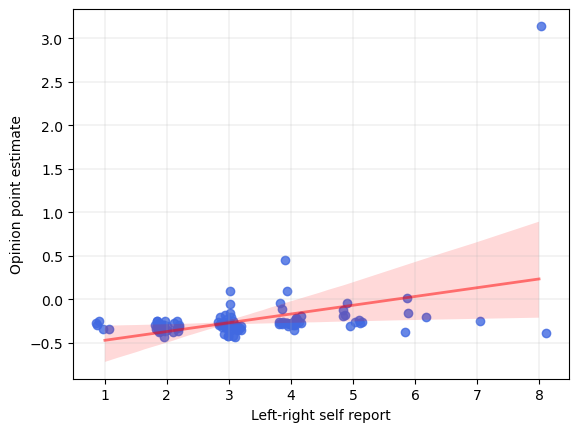

In [182]:
# Boxplot of latent latent dim value x left-right self report
sns.regplot(y='Dim 1', x='left_right', data=x_test2, ci=95, x_jitter=0.2, scatter_kws={'color': 'royalblue'}, line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})
#sns.set_style("whitegrid")
plt.grid(axis='both', linewidth=0.2)
plt.xlabel('Left-right self report')
plt.ylabel('Opinion point estimate')
plt.show()

## Check voting intention CA

In [102]:
# Value counts of party voted for in self-report dataset
x_test2['sundayq_1'].value_counts()

90/Greens    54
SPD          19
Other        18
LINKE        15
FDP           7
CDU/CSU       4
8             1
AfD           1
Name: sundayq_1, dtype: int64

/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 47.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nils/miniconda3/envs/tf/lib/python3.7/

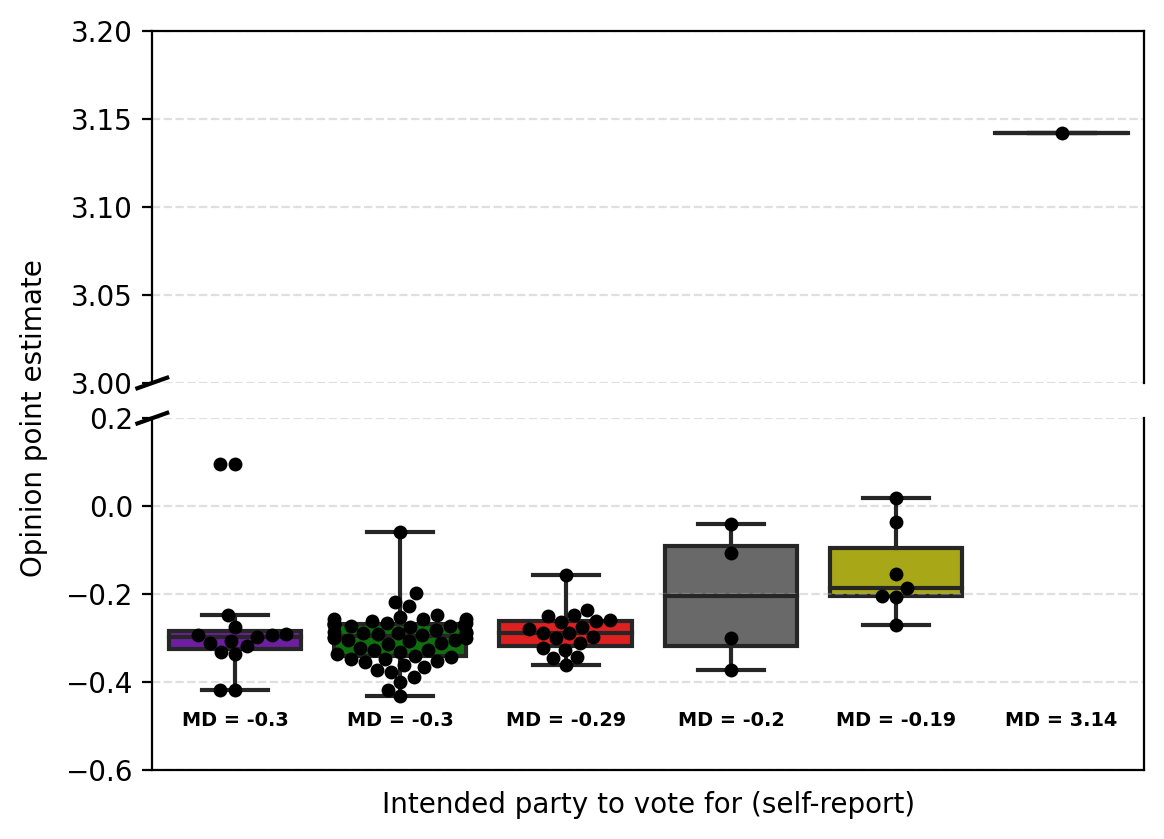

In [56]:
# Boxplot of latent dim value x party voted for
x_test3 = x_test2[(x_test2['sundayq_1']!= 'Other') & (x_test2['sundayq_1']!=8)]
palette = ['#7209B7', 'g', 'r', 'dimgrey', 'y', 'b']
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.1}, dpi = 200)
box = sns.boxplot(x='sundayq_1', y='Dim 1', data=x_test3, palette = palette, whis = 3, showfliers = False, ax = ax_top)
box = sns.boxplot(x='sundayq_1', y='Dim 1', data=x_test3, palette = palette, whis = 3, showfliers = False, ax = ax_bottom)
swarm = sns.swarmplot(x='sundayq_1', y='Dim 1', data=x_test3, color = 'black', dodge = True, ax=ax_top)
swarm = sns.swarmplot(x='sundayq_1', y='Dim 1', data=x_test3, color = 'black', dodge = True, ax=ax_bottom)

ax_top.set_ylim(3.0, 3.2)   # those limits are fake
ax_bottom.set_ylim(-0.6,0.2)
ax_top.grid(linestyle='--', alpha = 0.4, axis="y", zorder=0)
ax_bottom.grid(linestyle='--', alpha = 0.4, axis= "y", zorder=0)
ax_top.set_ylabel('')
tcks = len(box.get_xticklabels())
ax_top.set_xticks([])
ax_bottom.set_ylabel('')
plt.text(-1.3, 0.2, 'Opinion point estimate', va='center', rotation='vertical')
ax_bottom.set_xlabel('Intended party to vote for (self-report)')
ax_top.set_xlabel('')
sns.despine(ax=ax_bottom, right=False)
sns.despine(ax=ax_top, bottom=True, right=False, top=False)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagona

medians = x_test3.groupby(['sundayq_1'])['Dim 1'].median().round(2).sort_values()
ver_offset = -0.5
for tick in range(tcks):
     box.text(tick,ver_offset,str('MD = ' + str(medians[tick])), 
            horizontalalignment='center',size='x-small',color='black',weight='semibold')

plt.savefig('/home/nils/Documents/Seafile/PhD/PROJEKTE/OTHER/Twitter_data_Conny/analysis/pol_twitter_I/temp/PAPER/plots/CA/vote_CA.png', dpi=300, bbox_inches='tight')
plt.show()

# Supplementary analyses

Test set analyses with definite oos data (removal of rows already present in either training or validation dataset)

In [33]:
# Read data in
df_train = pd.read_csv("data_first_train.csv")
df_val = pd.read_csv("data_first_test.csv")
test = pd.read_parquet("foll_matrix_sample_matchClean_OOS.parquet.gzip")
selfr = pd.read_excel('df_vp_reduced.xlsx')

In [34]:
# Remove columns which are not political accounts
df_train = df_train.drop(columns=['BgmLudwig.csv', 'MullerAltermatt.csv'])
df_val = df_val.drop(columns=['BgmLudwig.csv', 'MullerAltermatt.csv'])

In [35]:
# Preprocess datasets
df_train = df_train.reset_index(drop=True) # reset index
df_val = df_val.reset_index(drop=True) # reset index

df_train = df_train.drop(columns=['Count', 'add_fol', 'dif','Unnamed: 0', '__index_level_0__']) # only use relevant columns
df_val = df_val.drop(columns=['Count', 'add_fol', 'dif','Unnamed: 0', '__index_level_0__']) # only use relevant columns

x_train = df_train # set x_train
x_val = df_val # set x_val
x_test = test.copy() # set x_test

In [36]:
# remove suffix from colnames
x_train.columns = x_train.columns.str.rsplit('.', 1).str[0]
x_val.columns = x_val.columns.str.rsplit('.', 1).str[0]
x_test.columns = x_test.columns.str.rsplit('.', 1).str[0]

In [37]:
# Get follower_id in test set already present in X-train & x_val, keep non matches
a =  set(x_test['id']).intersection(set(x_train['follower_id']))
b =  set(x_test['id']).intersection(set(x_val['follower_id']))
x_test = x_test[~x_test['id'].isin(a)] # keep non matches
x_test = x_test[~x_test['id'].isin(b)] # keep non matches

In [38]:
# Preprocess sample test set for performance check
x_test.columns = x_test.columns.str.rsplit('.', 1).str[0] #remove suffix
train_cols = x_train.columns
test_cols= x_test.columns
common_cols = train_cols.intersection(test_cols) #get test_cols
x_test = x_test[list(common_cols)]
x_test = x_test.loc[(x_test!=0).any(axis=1)]  # remove rows with all zeros

In [39]:
w = encoder_l.get_weights()
encoder_t = model.vanilla_encoder(x_test, w)
X3 = encoder_t.predict(x_test) #predict

# Copy dataset and set lat_id
t1 = x_test.copy()
t1['lat_id'] = pd.Series(X3[:,-1], index=x_test.index) # append to dataframe

2023-12-13 17:35:15.712400: W tensorflow/c/c_api.cc:291] Operation '{name:'total_3/Assign' id:2515 op device:{requested: '', assigned: ''} def:{{{node total_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_3, total_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-13 17:35:15.899118: W tensorflow/c/c_api.cc:291] Operation '{name:'Z-Mean_9/kernel/Assign' id:2787 op device:{requested: '', assigned: ''} def:{{{node Z-Mean_9/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Z-Mean_9/kernel, Z-Mean_9/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the

2023-12-13 17:35:21.109509: W tensorflow/c/c_api.cc:291] Operation '{name:'Decoder-Model_4/Decoder-Output-Layer/Sigmoid' id:2437 op device:{requested: '', assigned: ''} def:{{{node Decoder-Model_4/Decoder-Output-Layer/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](Decoder-Model_4/Decoder-Output-Layer/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Balanced accuracy score:  0.74
MCC:  0.43
Proportion correctly predicted 1.0
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    106741
           1       0.38      0.48      0.43       284

    accuracy                           1.00    107025
   macro avg       0.69      0.74      0.71    107025
weighted avg       1.00      1.00      1.00    107025



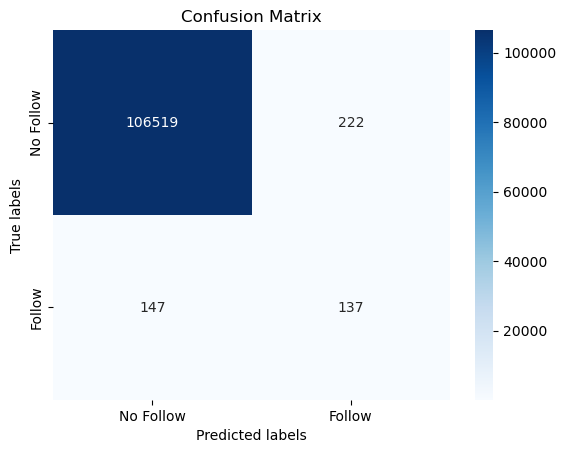

In [40]:
#### TEST SET PERFORMANCE (SAMPLE) ####

# Get performance of autoencoder on final test set
pred = vae_t.predict(x_test) #predict new matrix

model.mlmetrics(np.array(x_test),pred) 

Self report

In [51]:
## Read in sonntag data and following matrix of sample data
test = pd.read_parquet("foll_matrix_sample_matchClean_OOS.parquet.gzip") #read foll matrix of sample data
self_snt = pd.read_excel('sonntag.xlsx') # read sonntag frage
test.columns = test.columns.str.rsplit('.', 1).str[0] #remove suffix
x_full = pd.concat([x_train, x_val], axis=0)
full_cols = x_full.columns
test_cols= test.columns
common_cols = full_cols.intersection(test_cols) #get test_cols
x_test_c = test[list(common_cols)] # only keep intersecting columns
x_test_c['randomid'] = test['randomid'] # copy randomid over
x_test_c['id'] = test['id'] # copy id over

/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/nils/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [52]:
# Get follower_id in test set already present in x_train & x_val, keep non matches
a =  set(x_test_c['id']).intersection(set(x_train['follower_id']))
b =  set(x_test_c['id']).intersection(set(x_val['follower_id']))
x_test_c = x_test_c[~x_test_c['id'].isin(a)] # keep non matches
x_test_c = x_test_c[~x_test_c['id'].isin(b)] # keep non matches

In [53]:
# Remove rows with all zeros for comparability with CA model --> SUPPLEMENTARY ANALYSES
s = x_test_c.iloc[:,:-2].eq(0).all(1) #check if all values in a row are 0 except the last one (randomid), return boolean series of index
x_test_c = x_test_c.drop(s[s].index, axis= 'index') # remove rows with all zeros by index

In [59]:
# Predict latent dim for sample data and append to dataframe. !Uncomment first two rows to rerun encoder prediction, otherwise read in saved arrays

#X2 = encoder_t.predict(x_test_c.iloc[:,:-2]) #predict
#x_test_c['lat_id'] = pd.Series(X2[:,-1], index=x_test_c.index) # append to dataframe
#pd.DataFrame(X2).to_csv('encoder_predVot_OOS.csv') # save arrays

X3 = pd.read_csv('encoder_predVot_OOS.csv') # read saved arrays
x_test_c['lat_id'] = pd.Series(X3.to_numpy()[:,-1], index=x_test_c.index)# append to dataframe

In [60]:
# Merge datasets self report, sonntag and sample data
test2 = x_test_c.merge(selfr[['randomid', 'left_right']], left_on='randomid', right_on='randomid') #merge first dataset
test2 = test2.merge(self_snt[['randomid', 'sundayq_1']], left_on='randomid', right_on='randomid') #merge sec dataset

In [61]:
x_test2 = test2.dropna(axis=0) #drop NAs

x_test2['sundayq_1'] = x_test2['sundayq_1'].astype('category') #recode sunday question to categorical 
x_test2['sundayq_1'].replace({1: 'AfD', 2: '90/Greens', 3:'CDU/CSU', 4:'FDP', 5:'LINKE', 6:'SPD', 7:'Other', 8:'No vote'}, inplace=True) #label 

Correlations between lat_id and self reported ideology

In [92]:
# Descriptives 
print(x_test2[['lat_id', 'left_right']].describe())
print(x_test2['sundayq_1'].value_counts())

          lat_id  left_right
count  75.000000   75.000000
mean   -0.639122    3.240000
std     0.540876    1.037669
min    -1.670931    1.000000
25%    -0.943837    3.000000
50%    -0.707278    3.000000
75%    -0.417504    4.000000
max     1.049489    7.000000
90/Greens    35
Other        17
SPD          10
LINKE         9
CDU/CSU       3
FDP           1
Name: sundayq_1, dtype: int64


In [62]:
# Spearman correlation between latent dimension and self report left right
corLR = scipy.stats.spearmanr(x_test2['lat_id'], x_test2['left_right'])
print('Correlation latent dim with ideology (left-right):', np.round(corLR.correlation, 2),'\n', 'p-value', corLR.pvalue)

Correlation latent dim with ideology (left-right): 0.49 
 p-value 9.697634545672006e-06


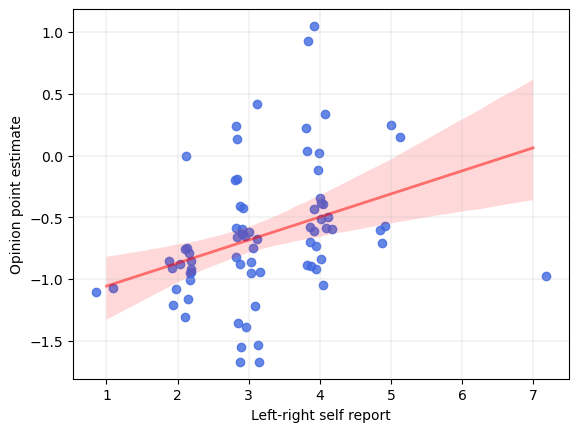

In [94]:
# Regplot of latent latent dim value x left-right self report
g = sns.regplot(y='lat_id', x='left_right', data=x_test2, ci=95, x_jitter=0.2, scatter_kws={'color': 'royalblue'}, line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})
sns.reset_orig()
plt.grid(axis='both', linewidth=0.2)
plt.xlabel('Left-right self report')
plt.ylabel('Opinion point estimate')
plt.show()

Check voting intention 

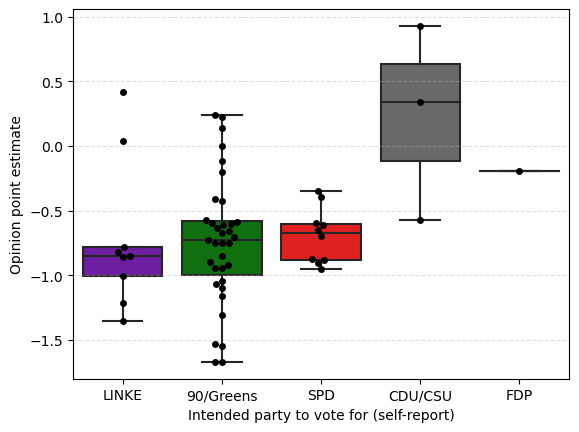

In [95]:
# Boxplot of latent dim value x party voted for, excluding other and no vote (AfD not present anymore)

palette = ['#7209B7', 'g', 'r', 'dimgrey', 'y', 'b']
sns.boxplot(x='sundayq_1', y='lat_id', data=x_test2[(x_test2['sundayq_1']!= 'Other') & (x_test2['sundayq_1']!='No vote')], palette = palette, whis = 3, showfliers = False)
sns.swarmplot(x='sundayq_1', y='lat_id', data=x_test2[(x_test2['sundayq_1']!= 'Other') & (x_test2['sundayq_1']!='No vote')], color = 'black', dodge = True)
plt.grid(axis='y', linestyle='--', alpha = 0.4)
plt.xlabel('Intended party to vote for (self-report)')
plt.ylabel('Opinion point estimate')
plt.show()